In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.minmax_normalizer import MinMaxNormalization
import time

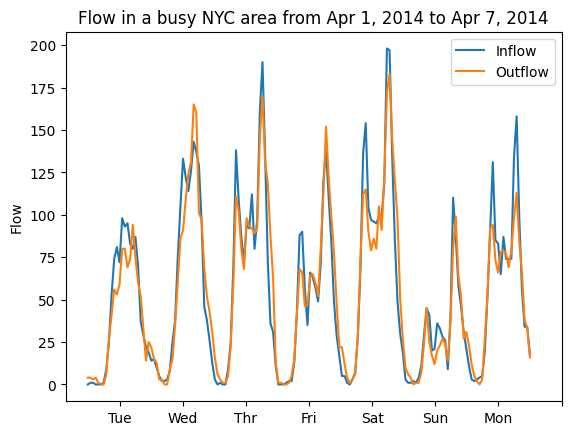

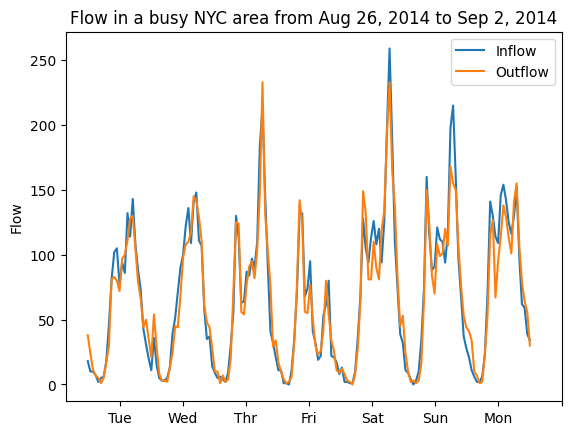

In [2]:
x, y = 10, 3
flow_data = np.load('./Datasets/BikeNYC/flow_data.npy')
fig = plt.figure()
in_flow = flow_data[24*7*0:24*7*1,0,x,y]
out_flow = flow_data[24*7*0:24*7*1,1,x,y]
t = np.linspace(1, 168, num=168)
plt.plot(t,in_flow,label='Inflow')
plt.plot(t,out_flow,label='Outflow')
plt.xticks(np.linspace(1+12, 168+12, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
plt.title('Flow in a busy NYC area from Apr 1, 2014 to Apr 7, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()
fig = plt.figure()
in_flow = flow_data[24*7*21:24*7*22,0,x,y]
out_flow = flow_data[24*7*21:24*7*22,1,x,y]
t = np.linspace(1, 168, num=168)
plt.plot(t,in_flow,label='Inflow')
plt.plot(t,out_flow,label='Outflow')
plt.xticks(np.linspace(1+12, 168+12, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
plt.title('Flow in a busy NYC area from Aug 26, 2014 to Sep 2, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()

In [3]:
def get_bikenyc_data(flow_data,n_closeness,n_period,n_trend,tt_split,g_closeness=1,g_period=24,g_trend=24*7):
    data_len, feature, map_height, map_width = flow_data.shape
    assert ((n_closeness,n_period,n_trend) < (7,4,3))
    start_idx = g_trend*n_trend
    total_samples = data_len-start_idx
    n_train = int(total_samples*tt_split)
    n_test = total_samples-n_train
    mmn = MinMaxNormalization()
    flow_data = mmn.fit_transform(flow_data)
    
    tstamp_train = np.zeros(n_train)
    y_train = np.zeros((n_train,2,map_height,map_width))
    x_closeness_train = np.zeros((n_train,n_closeness,2,map_height,map_width))    
    x_period_train = np.zeros((n_train,n_period,2,map_height,map_width))
    x_trend_train = np.zeros((n_train,n_trend,2,map_height,map_width))
    k = 0
    for i in range(start_idx,start_idx+n_train):    
        tstamp_train[k] = i
        y_train[k,:,:,:] = flow_data[i,:,:,:]
        l = 0
        for j in range(i-g_trend, i-g_trend*(n_trend+1), -g_trend):
            x_trend_train[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1        
        l = 0
        for j in range(i-g_period, i-g_period*(n_period+1), -g_period):            
            x_period_train[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        l = 0
        for j in range(i-g_closeness, i-g_closeness*(n_closeness+1), -g_closeness):            
            x_closeness_train[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        k += 1    
    x_closeness_train = x_closeness_train.reshape(n_train,-1,map_height,map_width)
    x_period_train = x_period_train.reshape(n_train,-1,map_height,map_width)
    x_trend_train = x_trend_train.reshape(n_train,-1,map_height,map_width)
    
    start_idx += n_train
    tstamp_test = np.zeros(n_test)
    y_test = np.zeros((n_test,2,map_height,map_width))
    x_closeness_test = np.zeros((n_test,n_closeness,2,map_height,map_width))    
    x_period_test = np.zeros((n_test,n_period,2,map_height,map_width))
    x_trend_test = np.zeros((n_test,n_trend,2,map_height,map_width))
    k = 0
    for i in range(start_idx,start_idx+n_test):
        tstamp_test[k] = i
        y_test[k,:,:,:] = flow_data[i,:,:,:]
        l = 0
        for j in range(i-g_trend, i-g_trend*(n_trend+1), -g_trend):
            x_trend_test[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1        
        l = 0
        for j in range(i-g_period, i-g_period*(n_period+1), -g_period):            
            x_period_test[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        l = 0
        for j in range(i-g_closeness, i-g_closeness*(n_closeness+1), -g_closeness):            
            x_closeness_test[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        k += 1
    x_closeness_test = x_closeness_test.reshape(n_test,-1,map_height,map_width)
    x_period_test = x_period_test.reshape(n_test,-1,map_height,map_width)
    x_trend_test = x_trend_test.reshape(n_test,-1,map_height,map_width)
    
    return tstamp_train, x_closeness_train, x_period_train, x_trend_train, y_train, x_closeness_test, x_period_test, x_trend_test, y_test, mmn
    
# d = get_bikenyc_data(flow_data,4,1,1,0.8)

In [4]:
import torch
from torch.utils.data import Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BikeNYCDataset(Dataset):
    def __init__(self,path,n_closeness,n_period,n_trend,tt_split,train=True):
        flow_data = np.load(path+'flow_data.npy')            
        if train:
            _, self.x_c, self.x_p, self.x_t, self.y, _, _, _, _, self.mmn = get_bikenyc_data(flow_data,n_closeness,n_period,n_trend,tt_split)
        else:
            _, _, _, _, _, self.x_c, self.x_p, self.x_t, self.y, self.mmn = get_bikenyc_data(flow_data,n_closeness,n_period,n_trend,tt_split)
        self.dataset_len = self.y.shape[0]
        self.y = torch.tensor(self.y, device=torch.device(device)).float()
        self.x_c = torch.tensor(self.x_c, device=torch.device(device)).float()
        self.x_p = torch.tensor(self.x_p, device=torch.device(device)).float()
        self.x_t = torch.tensor(self.x_t, device=torch.device(device)).float()
        print(self.x_c.shape, self.x_p.shape, self.x_t.shape) 

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        return self.x_c[idx], self.x_p[idx], self.x_t[idx], self.y[idx]

bikenyc_dataset = BikeNYCDataset('./Datasets/BikeNYC/',4,1,1,0.8,True)

min: 0.0 max: 737.0
torch.Size([3379, 8, 21, 12]) torch.Size([3379, 2, 21, 12]) torch.Size([3379, 2, 21, 12])
